# Lab 4: Kalman Filtering and Online Bayesian Inference

### Lab Date: Wednesday, February 19

### Parts II and III Due: Wednesday, February 26

## Instructions

Work with your lab group to complete the following notebook. Your work on Part I will be reviewed by your peers in lab next week (Wednesday, February 26th). This is the second half of the lab you started last week. To access the first half, click this link: [Lab 3](https://datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fberkeley-stat238%2Fspring-2025&urlpath=tree%2Fspring-2025%2Flabs%2Flab03%2FLab_3.ipynb&branch=main)

In this lab, you will:

1. *Practice with our next family of conjugate models: the normal-normal model, [Part I]*
1. See how easily (some) conjugate models extend to thorny multi-dimensional problems, and thus, why they are so popular as building blocks for large problems, [Part I and II]
1. See how the self-consistency of Bayesian inference allows for straightforward on-line inference (inference as the data is collected). [Parts II and III]

Together, these demonstrate two of the common selling points for Bayesian methods: (1) they extend easily and consistently to multiple dimensions without requiring the user to make arbitrary choices to reduce dimension (e.g. picking a test statistic), (2) they are very natural to work with when tracking sequential data. It also demonstrates a subtler computational message. The larger our problems, the more useful analytic results are. As you read ahead, try to imagine what the procedure would look like if we replaced the simple algebra that follows from conjugacy with sampling, or, god forbid, numerical integration.

These learning goals will be presented to you through the Kalman filter, a fundamental tool for data assimilation in dynamical systems. The Kalman filter is an iterated application of a Gaussian likelihood, a Gaussian prior on the mean, and a linear update model to represent a dynamical system with a measurement protocol. Until this year, this approach was state-of-the-art for very large online prediction problems such as weather forecasting (see [GraphCast, 2023](https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/) and [GenCast, Nature, 2025](https://www.nature.com/articles/s41586-024-08252-9)).

The Kalman filter involves a lot of algebra. We've scaffolded that algebra, and the associated inferential code, for you. Focus on the statistical story represented in the algebra. 

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6147286) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. You may use the same procedure you used last week to work with that folder. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

In [1]:
# load whatever packages you prefer here. We've added a reference list here
import numpy as np
import matplotlib.pyplot as plt

## [PART I - Reference] Conjugate Gaussian Models

I've copied some of the reference text from part I here. To access lab 3 click this link: [Lab 3](https://datahub.berkeley.edu/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fberkeley-stat238%2Fspring-2025&urlpath=tree%2Fspring-2025%2Flabs%2Flab03%2FLab_3.ipynb&branch=main).

You are welcome to copy other components of your group's work on lab 3 here as reference.


So far we've looked at one family of conjugate models, the (Beta, Binomial). In this lab we'll be working with the next natural conjugate family, the (Normal, Normal) family. For reference, see BDA Chapter 2.5, 3.2, and 3.3.

### The Model:

Consider a joint model of the form:
- **Prior:** $M \sim \mathcal{N}(\hat{m},C_{m})$ where $\hat{m} = \mathbb{E}[M]$ and $C_{m} = \text{Cov}[M]$
- **Likelihood:** $Y|M = m \sim \mathcal{N}(m,C_y)$ where $C_y$ is the covariance in $X$ given $m$.

This is a conditionally Gaussian model for $Y$, conditioned on an unknown mean, $M$. In this context, $C_y$ is often interpreted as the covariance of some noise. Combining a Gaussian prior with a conditionally Gaussian likelihood produces an elegant conjugate family. This family is very convenient for large problems, since it allows analytic posterior inference in arbitrary dimension. The inference proceeds via a sequence of linear algebraic updates, so is easy to apply as a step in larger inferential problems.

### Solving for the Posterior (in $d$ Dimensions)

*Save deriving the update in multiple dimensions for the end of your lab work. It is worth doing once to justify the heavier formulas that come later. All the main ideas were captured in the 1D example. We will do parts of this in class on Thursday.*

**Q1.6:** In the cell below, repeat the analysis you performed in the 1D case for the generic case. That is, for $M$ and $Y$ in $\mathbb{R}^d$. It helps to be strategic here. Follow the same sequence of steps you performed in the 1D case, dropping constants everywhere you can. If you need help completing the square in multiple dimensions, come talk to us in office hours or raise a hand.

*Copy in your answer from lab 3*

### Inspecting the Update Rule

In the previous cell you should have derived the following update:

$$M|Y = y \sim \mathcal{N}(\hat{m}_{|y},C_{m|y}) \text{ where: } \begin{cases} & \hat{m}_{|y} = \hat{m} + (I + C_m^{-1} C_y)^{-1} (y - \hat{m}) \\ & C_{m|y} = (C_m^{-1} + C_y^{-1})^{-1} \end{cases}$$

There are a couple things to note here.
1. The update is entirely expressed by updating the parameters (here, the mean and the covariance). Here we see the power of conjugacy on full display. Moreover, if we observe multiple samples observations sequentially, then we can just update the mean and covariance recursively. 
1. The mean update is sensible. As before, it updates the mean by shifting it towards the observation. The product $C_m^{-1} C_y$ is playing the role of the (inverse) SNR. If the covariance in the measurement is much larger than the covariance in the noise, then this term is small, so $(I + C_m^{-1} C_y)^{-1} \approx I$, so $\hat{m}_{|y} \approx \hat{m}$.
1. The covariance is update is sensible. As before, the precisions add after the observation.


These sorts of updates can be easily extended to similar scenarios. For example, since all linear transformations of normal distributions are normal, we can derive a similar rule for the conditional distribution of some unknown mean $M$ when the observable $Y$ is expressed as a linear transformation of $M$, plus Gaussian noise. That is $y = H m + \epsilon$ where $\epsilon \sim \mathcal{N}(0,C_{y})$ represents the noise, $H$ represents the mapping responsible for converting state to measurement, and where we have used lower case letters for $y$ and $m$ to distinguish vectors from matrices. This is a standard convention at this stage. In general, we will continue to use hats for fixed quantities (expected values), and capital letters for matrices.

Introducing a linear mapping between the unknown $m$ and the observation $y$ is useful since, in most high-dimensional settings, we have (far) fewer measurements than unknowns. We will assume that $A$ is $n \times d$ where, for, most practical purposes, $n \ll d$. 

Introducing the linear mapping only decorates the original expression. Read through the expression carefully to track the change in dimensions. Each time we switch from $n$ to $d$ we are moving from the measurement domain to the state space. Each time we map from $d$ to $n$ we are moving from the state space to the measurement space.

\begin{equation}
m|y \sim \mathcal{N}(\hat{m}_{|y},C_{m|y}) \text{ where: } \begin{cases} & \hat{m}_{|y} = \hat{m} + (C_m^{-1} + H^{\intercal} C_y^{-1} H)^{-1} H^{\intercal} C_y (y - H \hat{m}) \\ & C_{m|y} = (C_m^{-1} + H^{\intercal} C_y^{-1} H)^{-1} \end{cases}
\end{equation}

For the next part, it will also be convenient to understand how the posterior distribution updates if we replace $m$ with $A m + \zeta$ where $zeta \sim \mathcal{N}(0,C_{\zeta})$, and $A \in \mathbb{R}^{d \times d}$ is invertible. This represents a noisy linear transformation of $m$. 

## [PART II] Kalman Filters

Consider the following problem:

You are a meteorologist insterested in predicting the weather. You have access to a large, varied, set of real-time data sources. These provide a constant stream of measurements. Even so, the real weather system is unimaginably high-dimensional. So, even with input from satellites, and weather stations, and weather bouys, and balloon launches, and everything else NOA attempts, omniscience is still far off. Given your data, the true state of the weather at any time is unknown.

Worse still, the weather is constantly changing. 

These two ingredients pose a data assimilation problem. In data assimilation, we make measurements in real time of an unknown, *potentially changing*, quantity, usually called the state vector. Unlike the examples we've considered before, asymptotic consistency guarantees don't apply since the unknown is constantly moving. Our aim is to keep ``assimilating" new data into a model for the motion of the unknown in order to keep a good guess at the range of possible states given the observed sequence of measurements. In other words, we want to sequentially update a posterior after each measurement.

Data assimilation has two key components:
1. A dynamical systems model that specifies how we would expect the state vector to change over time if we knew it's exact initial conditions at some point in time. This system may be deterministic, or stochastic. In the weather analogy, this is a massive PDE simulator, built on a combination of fundamental physics (i.e. Navier-Stokes) and geochemistry (water cycles, etc.). In all that follows the true, but unknown, state of the system will be represented as $x(t)$ (if in continuous time), or $x_t$ in discrete time. We will treat this as random quantity, but use lower case letters to maintain a clear distinction between matrices and vectors.
1. A statistical model that specifies a prior distribution over the unknowns before any measurement, and an error model relating the true state of the system to the observed measurements. In all that follows we will let $y_t$ represent the measurements made at time $t$. Typically, $y_t$ is a low dimensional object relative to $x_t$. Hence, we are in the standard "small sample" statistics regime of Bayesian statistics where we aim to repeatedly solve an ill-posed problem.

Then, we update a posterior distribution after each new measurement, using the posterior after the previous measurement as our prior, and using the dynamical systems model and measurement model to specify the likelihood.

A Kalman filter linearizes the dynamical system and measurement model (assumes small time steps and concentrated posteriors), and uses a (Normal, Normal) conjugate model. In this setting, the posterior over the unknown state remains Gaussian at all times. Since a Gaussian is fully specified by its mean and covariance, applying data assimilation reduces to running an algebraic recursion driven by a constant stream of input measurements.

### An overview.

The idea in a Kalman filter is to continuously update a Gaussian approximation to the posterior distribution of the unknown state given a series of sequential measurements. In what follows, let $x_t$ denote the (unknown) state at time $t$, and $y_t$ denote the corresponding observation. Between each observations, $x_t$ is updated by a noisy dynamical system. As long as the time step is small, the mapping imposed by the system is approximately linear. Similarly, as long as we can collect enough measurements to keep the posterior concentrated, then the action of any, potentially nonlinear, set of measurement functions, are approximately linear. Then, every update is either, a linear transformation plus Gaussian noise, or a posterior inference step based on a linear measurement. Each of these steps preserve the family of Gaussian distributions, so the entire pipeline can be represented by deriving a recursion on the mean and covariance of the state vector $\{\hat{x}_t,P_t\}_{t=1}^{...}$. Since we will condition on all past observations to constrain our inference, we will write, $\hat{x}_{t|t-1},P_{t|t-1}$ to denote the posterior mean and covariance over the state vector after measurement $y_t$. 

Then, after initializing with a Gaussian prior mean $\hat{x}_0$ and covariance $P_0$, we will run a recursive process of the form:

1. Push the posterior distribution left after the observation at time $t$ forward to a prior for time $t+1$ by running the dynamics (apply the linear update equation you derived in Q 1.7).
1. Make an observation, $y_{t}$
1. Condition on the observation, using the new prior, to derive a new posterior via equation (1).
1. Iterate.

All of the algebra below is just a clever implementation of this idea.



### Example: Simple Harmonic Oscillators

A simple harmonic oscillator obeys the dynamical system: 

\begin{equation}
\frac{d^2 x}{d t^2} + \omega^2 x =0
\end{equation}

This is an interesting first test case since it is, in a sense, as about as easy an example as possible without resorting to convergent models that stop changing after some time. 

Harmonic oscillators are an example of a special class of dynamical systems call Hamiltonian systems. These have the remarkable property that they conserve volume. That is, if you initialize the dynamical system with an infinite collection of initial conditions on the boundary of some closed region, then the volume enclosed as the boundary evolves forward under the dynamic, will remain the same. Systems with the property preserve the entropy of any continuous distribution of states evolving under the dynamic. We'll see why this is useful in a moment.

### Step 1: Define the State-Space Model
A state-space model consists of a system equation and a measurement equation. The system equation describes how the true state evolves over time, while the measurement equation describes how observations are obtained. 

The state equation is given by:
$$ x_{t+1} = A_t x_t + w_t $$
where $x_t$ is the state vector at time $t$, $A_t$ is the transition matrix, and $w_t$ is process noise, assumed to be Gaussian with covariance $Q$. Note that $A_t$ could depend on time. This happens for nonlinear dynamics. Then, it is standard to set $A_t$ to the Jacobian of the dynamical system evaluated at $\hat{x}_t$. If the dynamical system is Hamiltonian, then the mapping $A_t$ must also be volume preserving. It follows that $A_t$ is a *unitary* transformation. This means that, in a sense, multiplying by $A_t$ will preserve the covariance of the posterior distribution.

**Q 2.1:** Assume that $A$ is a unitary matrix (its determinant equals 1). In the space below, show that, the determinant of the covariance of a random vector is preserved if we transform its output $x$ by the linear transformation $T(x) = A x$. Show that, if the determinant of the covariance is preserved, then the transformation preserves the geometric mean of the principal variances (eigenvalues of the covariance).


*Fill your answer here.*

This means that, in a sense, under the dynamic alone, the distribution of possible state vectors will not spread out too quickly. However, it does not guarantee that the dynamic will not stretch or compress the distribution along a particular direction. It only guarantees that the geometric average of the stretching and compression factors balance out to 1.

The measurement equation is given by:
$$ y_t = H_t x_t + v_t $$
where $y_t$ is the observed measurement, $H_t$ is the observation matrix, and $v_t$ is measurement noise, assumed to be Gaussian with covariance $R$. As before, the measurement matrix could, in principle, change in time if we are linearizing a nonlinear measurement function. For now, we will assume $H_t$ is fixed.

In [2]:
# Define the state-space model
dt = 0.1  # Time step
omega = 1.0  # Natural frequency
A = np.array([[1, dt], [-omega**2 * dt, 1]])  # State transition matrix
H = np.array([[1, 0]])  # Measurement matrix
Q = np.eye(2) * 0.01  # Process noise covariance
R = np.eye(1) * 0.1  # Measurement noise covariance

# Initialize state estimate and covariance
x_est = np.array([[1], [0]])  # Initial position and velocity
P = np.eye(2) * 1.0  # Initial uncertainty

# Simulate noisy measurements
time_steps = 100
true_states = []
measurements = []
for _ in range(time_steps):
    x_est = A @ x_est + np.random.multivariate_normal(mean=[0, 0], cov=Q).reshape(-1, 1) # Propagate state forward
    measurement = H @ x_est + np.random.normal(0, np.sqrt(R[0, 0]))  # Add measurement noise
    true_states.append(x_est.flatten())
    measurements.append(measurement.flatten())

### Step 2: Compute the Prediction Step
In this step, we use the state equation to predict the next state based on the current estimate. This involves two calculations:

1. **State Prediction:**
   $$ \hat{x}_{t|t-1} = A x_{t-1|t-1} $$
   This equation propagates the previous estimate through the state model to predict the next state.

2. **Covariance Prediction:**
   $$ P_{t|t-1} = A P_{t-1|t-1} A^T + Q $$
   Here, we compute the predicted covariance, which accounts for the uncertainty in the process model.

### Step 3: Compute the Kalman Gain
The Kalman Gain determines how much weight should be given to the new measurement versus the predicted state. It is calculated as:
$$ K_t = P_{t|t-1} H^T (H P_{t|t-1} H^T + R)^{-1} $$
This equation balances the confidence in the measurement against the predicted uncertainty.

### Step 4: Compute the Update Step
Once a new measurement $y_t$ is received, the state estimate is updated. This is done using:

1. **State Update:**
   $$ \hat{x}_{t} = \hat{x}_{t|t-1} + K_t (y_t - H \hat{x}_{t|t-1}) $$
   This equation corrects the predicted state using the difference (innovation) between the actual measurement and the predicted measurement.

2. **Covariance Update:**
   $$ P_{t} = (I - K_t H) P_{t|t-1} $$
   Here, the covariance is updated to reflect the reduced uncertainty after incorporating the new measurement.

### Step 5: Implement the Kalman Filter
Now that we have derived the equations, we implement the Kalman Filter iteratively over multiple time steps. At each step, we:
1. Use the state transition model to predict the next state.
2. Compute the Kalman Gain to determine the weight of the new measurement.
3. Update the state estimate based on the new measurement.
4. Update the covariance to reflect new uncertainty levels.
5. Repeat for all incoming measurements.

In [3]:
# Implement the Kalman Filter
filtered_states = []
for z in measurements:
    # Prediction Step
    x_pred = A @ x_est
    P_pred = A @ P @ A.T + Q
    
    # Compute Kalman Gain
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    
    # Update Step
    x_est = x_pred + K @ (z - H @ x_pred)
    P = (np.eye(2) - K @ H) @ P_pred
    
    filtered_states.append(x_est.flatten())

### Step 6: Visualizing the Results
To understand how well the Kalman Filter performs, we plot the following elements:
1. **True State**: The actual underlying system state.
2. **Filtered State**: The estimated state obtained from the Kalman Filter.
3. **Measurements**: The noisy observations received over time.

The plot helps visualize how closely the Kalman Filter is able to track the true state despite noisy measurements. We expect the filtered state to be smoother than the measurements and follow the trend of the true state closely.

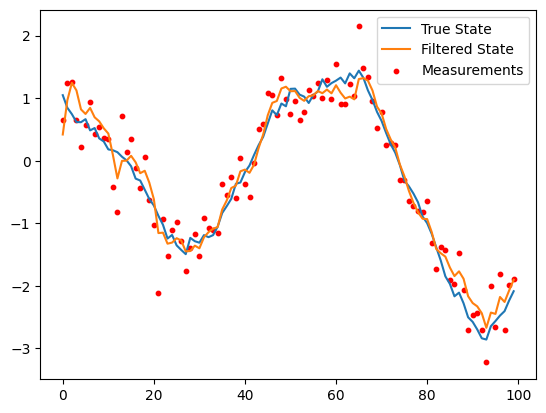

In [4]:
# Plot the results
plt.plot([s[0] for s in true_states], label='True State')
plt.plot([s[0] for s in filtered_states], label='Filtered State')
plt.scatter(range(time_steps), [m[0] for m in measurements], label='Measurements', color='red', s=10)
plt.legend()
plt.show()

## [PART III] Application: Lorenz System Equations
The Lorenz system is a set of three differential equations used to model chaotic behavior:

$$
\frac{dx}{dt} = \sigma (y - x), \quad \frac{dy}{dt} = x (\rho - z) - y, \quad \frac{dz}{dt} = xy - \beta z
$$

where $\sigma$, $\rho$, and $\beta$ are system parameters that control the chaotic behavior of the system. These equations describe the evolution of three state variables $x, y, z$ over time. This system was first derived as an extremely simplified weather model based. It is famous as the dynamical systems model which led to the discovery of chaotic dynamical systems.

Unlike the harmonic oscillator example, the Lorenz system is chaotic. This means that, given long enough, any pair of state vectors initialized from the same location will spread arbitrarily far apart, and mix over some attractor. For the Lorenz system, this attractor is the eponymous "butterfly". It is, in part, for this reason that accurate weather prediction beyond ten days remains an unsolved scientific problem.

Chaotic systems are almost the worst possible case for data assimilation. In a chaotic system, we are constantly using measurement to tamp down the ever expanding uncertainty produced by the dynamic. Chaos is also typical for real systems where data assimilation is used. Most notably, weather prediction. 

### Discretize the System
Since the Kalman filter operates in discrete time, we need to approximate the continuous Lorenz equations using a numerical method. We use the Runge-Kutta method to integrate the system over small time steps, ensuring accuracy in tracking the chaotic dynamics.

### Step 1: Generate Noisy Observations
In real-world applications, measurements are subject to noise. We assume that only the \( x \) and \( y \) components are observable and introduce Gaussian noise to simulate sensor inaccuracies:

$$ y_t = H x_t + v_t $$

where \( v_t \) is Gaussian measurement noise with covariance \( R \).

In [5]:
from scipy.integrate import solve_ivp

# Lorenz system parameters
sigma, rho, beta = 10, 28, 8/3
dt = 0.01  # Time step

# Define the Lorenz system
def lorenz_system(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Solve Lorenz system numerically
time_span = np.linspace(0, 2, 200)
sol = solve_ivp(lorenz_system, [time_span[0], time_span[-1]], [1, 1, 1], t_eval=time_span)

# Observation matrix (assume we only observe x and y)
H = np.array([[1, 0, 0], [0, 1, 0]])
Q = np.eye(3) * 0.1  # Process noise covariance
R = np.eye(2) * 1.0  # Measurement noise covariance

# Initial state and covariance
x_est = np.array([[1], [1], [1]])
P = np.eye(3) * 1.0

# Generate noisy observations
measurements = sol.y[:2].T + np.random.normal(0, 1, (len(time_span), 2))

### Step 2: Compute the Prediction Step
At each time step, we predict the next state using the system dynamics:

1. **State Prediction:**
   $$ \hat{x}_{t|t-1} = x_t $$
   Since the Lorenz system is nonlinear, we approximate the state transition without an explicit transition matrix.

2. **Covariance Prediction:**
   $$ P_{t|t-1} = P_t + Q $$
   Here, $Q$ represents process noise, capturing uncertainty in the system evolution.

### Step 3: Compute the Kalman Gain
The Kalman gain determines how much weight is given to the new measurements:

$$ K_t = P_{t|t-1} H^T (H P_{t|t-1} H^T + R)^{-1} $$

This equation balances trust in the prediction versus the new observation.

### Step 4: Compute the Update Step
When a new measurement $y_t$ is available, we update our state estimate:

1. **State Update:**
   $$ x_{t|t} = \hat{x}_{t|t-1} + K_t (y_t - H \hat{x}_{t|t-1}) $$
   This correction ensures that the estimate accounts for the measurement innovation.

2. **Covariance Update:**
   $$ P_{t|t} = (I - K_t H) P_{t|t-1} $$
   Updating the covariance reduces uncertainty after incorporating the new measurement.

In [6]:
# Kalman filter implementation
filtered_states = []
for z in measurements:
    x_pred = x_est
    P_pred = P + Q
    
    K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + R)
    x_est = x_pred + K @ (z.reshape(-1, 1) - H @ x_pred)
    P = (np.eye(3) - K @ H) @ P_pred
    
    filtered_states.append(x_est.flatten())

filtered_states = np.array(filtered_states)

### Step 5: Implement the Kalman Filter and Visualize Results
To evaluate the filter’s performance, we plot:
1. **True State**: The numerically integrated Lorenz system.
2. **Filtered State**: The Kalman filter’s best estimate.
3. **Measurements**: The noisy observations.

This visualization helps assess how well the Kalman filter mitigates chaos-induced divergence.

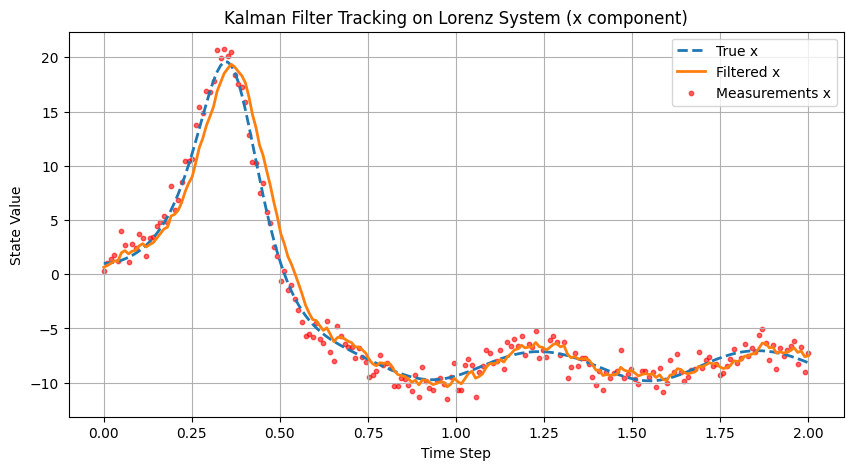

In [7]:
# Visualization
plt.figure(figsize=(10, 5))
plt.plot(time_span, sol.y[0], label='True x', linestyle='dashed', linewidth=2)
plt.plot(time_span, filtered_states[:, 0], label='Filtered x', linewidth=2)
plt.scatter(time_span, measurements[:, 0], label='Measurements x', color='red', s=10, alpha=0.6)
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.title('Kalman Filter Tracking on Lorenz System (x component)')
plt.legend()
plt.grid(True)
plt.show()

## Outro: A note on revolutions

As foreshadowed at the start of this lab, the Kalman filtering technique implemented above was the gold standard in many large data assimilation problems, particularly weather prediction, until this year. AI models trained on simulated weather data may not provide more skillful predictions (see [GraphCast, 2023](https://deepmind.google/discover/blog/graphcast-ai-model-for-faster-and-more-accurate-global-weather-forecasting/) and [GenCast, Nature, 2025](https://www.nature.com/articles/s41586-024-08252-9)).

How is this possible?

A simple answer is that trying to predict the behavior of the weather far in advance requires running many simulations of the dynamical system, initialized from different possible current states. That is, initialized from the current posterior. Because the dyanmic is chaotic, these rapidly spread out. Think about dropping a ball into a Plinko board. If you could exactly specify its position and momentum at the start, and the material properties of the ball and pins, and how the board is stabilized on the table, and how the ball interacts with the air, and its rolling friction against the board, and the exact surface topology of the board, then, in principle, you could predict where it would go, after many bounces, with high precision. Of course, this is essentially impossible. The ball's final position behaves as if it were random since we don't have complete information on the dynamic, or on the starting condition. If you have a highly concentrated prior over the initial conditions, then you may be able to precisely predict the ball's location after one or two bounces. However, the farther you look into the future, the faster your posterior will spread out. 

Weather simulations have exactly the same problem. Like Plinko, they also follow regualr statistical patterns over different time frames. For example, after many bounces, a ball descending a Plinko board will have a horizontal position that is roughly Gaussian distributed. If you haven't tried this, there are amazing demos (ask the instructor). So, while we may not be able to predict the exact motion of a particular ball, we could learn to approximate its distribution at any stage down the board, then use those distributions to model our uncertainty about the position of the ball. Moreover, since Plinko can be subdivided into many copies of the same problem, if we conditioned on an initial position for the ball, we could update our distributional estimate (e.g. our posterior) to reflect our observation.

In a Plinko board, you might imagine that the distribution produced by simulating the physics forward should mimic the physics closely enough that the simulated distribution would match the observed distribution over a long time frame. This is much harder for weather prediction. As a result, the simulated posterior looking far in advance may not capture long time statistical behavior of actual weather data. Alternately, since simulation is expensive, it may not sample finely enough.

In contrast, and AI model trained to imitate observed statistical patterns may sacrifice the step-by-step consistency of a physical simulation for the capacity to model observed long-time statistics. 